## Load required python libs

In [1]:
import numpy as np
import pandas as pd
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load the data and conduct a simple data exploratory analysis

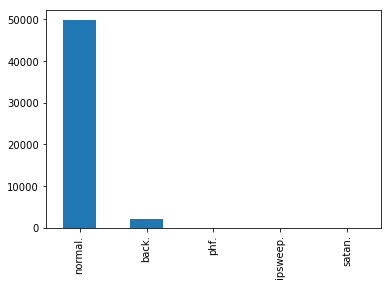

In [58]:
# load the data as a pandas dataframe
names = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
        'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
        'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
        'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
        'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
        'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
        'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','label']

kdd_dat = pd.read_csv('kddcup.data_10_percent.csv', header=None)
kdd_dat.columns = names

# extract just http access data used for the one-class SVM model
kdd_dat = kdd_dat[kdd_dat['service'] == "http"]  
dat = kdd_dat[kdd_dat["logged_in"] == 1]

# # # exploratory analysis to show the distribution of different types of access
dat.label.value_counts().plot(kind='bar') 

## Prepare data for the ocsvm training

In [79]:
# extract features, only 3 out of 41 are included
dat_subset = dat[['duration','src_bytes','dst_bytes','label']]

# normalization
dat_subset.loc["duration"] = np.log((dat_subset["duration"] + 0.1).astype(float))  
dat_subset.loc["src_bytes"] = np.log((dat_subset["src_bytes"] + 0.1).astype(float))  
dat_subset.loc["dst_bytes"] = np.log((dat_subset["dst_bytes"] + 0.1).astype(float)) 

In [80]:
# drop rows that contains NULL values
dat_transform = dat_subset.dropna(axis=0, how='any')

# transform the label names into numberic values, 1 means normal http access, -1 refers to abnormal ones.
dat_transform.loc[dat_transform['label'] == "normal.", "attack"] = 1  
dat_transform.loc[dat_transform['label'] != "normal.", "attack"] = -1

# # extract the labels of the dataset for test 
labels = dat_transform['attack']

# # get input that could be feed into the model
dat_transform.drop(["label", "attack"], axis=1, inplace=True)

# # split model input into different subsets for the svm training
train_X, test_X, train_y, test_y = train_test_split(dat_transform, labels, train_size = 0.8) 

In [88]:
train = train_X[train_y==1]

## Train the model and test it

In [89]:
# train the model
nu = 0.038
model = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.00005)  
model.fit(train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=5e-05, kernel='rbf',
      max_iter=-1, nu=0.038, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [90]:
# test the model
preds_y = model.predict(train_X)
preds_test_y = model.predict(test_X)

acc = metrics.accuracy_score(train_y, preds_y)
pres = metrics.precision_score(train_y, preds_y)
recl = metrics.recall_score(train_y, preds_y)
f1 = metrics.f1_score(train_y, preds_y)

print("Accuracy: ", acc)
print("Precision: ", pres)
print("Recall: ", recl)
print("F1-score: ", f1)

('Accuracy: ', 0.95948518955918149)
('Precision: ', 1.0)
('Recall: ', 0.95774258421317249)
('F1-score: ', 0.97841523388846796)


## How to use the model in production

In [ ]:
# save the model
outputfile = 'oneclass_v1.model'  
from sklearn.externals import joblib  
joblib.dump(model, outputfile, compress=9)

# load the model
from sklearn.externals import joblib  
model = joblib.load('oneclass_v1.model')